In [1]:
%matplotlib inline
import numpy as np
import time
import h5py
import keras
import pandas as pd
import math
import joblib

from sklearn.model_selection import train_test_split
from IPython.display import display

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Activation, Dropout
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


# Load SVHN dataset

In [2]:
f = h5py.File("../../data/svhn/svhn_format_2.hdf5", "r")
X_dataset, y_dataset = list(f.items())

# Use a nice round number divisible by our batch size
N=630000

X_dataset, y_dataset = np.moveaxis(X_dataset[1][:N], 1, 3), y_dataset[1][:N]
print ("Full Dataset - DType X=%s, y=%s" % (X_dataset.dtype, y_dataset.dtype))
print ("Full Dataset - Shape X=%s, y=%s" % (X_dataset.shape, y_dataset.shape))

# Extract out our train/validation set
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.1)
print ("Train - Shape X=%s, y=%s" % (X_train.shape, y_test.shape))
print ("Test - Shape X=%s, y=%s" % (X_test.shape, y_test.shape))

# Save some RAM
del X_dataset
del y_dataset

Full Dataset - DType X=uint8, y=uint8
Full Dataset - Shape X=(630000, 32, 32, 3), y=(630000, 1)
Train - Shape X=(567000, 32, 32, 3), y=(63000, 1)
Test - Shape X=(63000, 32, 32, 3), y=(63000, 1)


# Load PCA model

(see corresponding `process_svhn.ipynb` notebook)

In [3]:
pca_model_file = 'saved_models/pca_1000.pkl'
pca = joblib.load(pca_model_file)
n_components = pca.n_components_
pca

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

# Data Generator

Create a data generator so we don't have to store the entire transformed dataset in RAM.  We'll transform to PCA space on the fly to simplify things (and save RAM).

In [4]:
def data_generator(X_train, pca, batch_size):
    n = 0
    while True:
        for i in range(batch_size):
            batch = pca.transform(X_train[i + n: i + n + batch_size].reshape(batch_size, -1) / 255.)
            yield batch, batch

# Test the data generator out
X_test_pca = pca.transform(X_test.reshape(len(X_test), -1) / 255.)
print("Shape X_test=%s" % str(X_test.shape))
print("Shape X_test_pca=%s" % str(X_test_pca.shape))

Shape X_test=(63000, 32, 32, 3)
Shape X_test_pca=(63000, 1000)


# Variational Autoencoder Parameters

In [5]:
img_rows, img_cols, img_chns = 32, 32, 3

if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

batch_size = 1000
latent_dim = 512
intermediate_dim = 2048
epsilon_std = 1.0
epochs = 1000
activation = 'relu'
dropout = 0.4
var_epsilon = 0.025
learning_rate = 0.0001

# Encoder Network

* Input layer - 1000 dimensions(PCA transformed space)
* 3 fully connected dense layers (batch norm, 'relu' activiation, dropout) - 2048 neurons each
* z_mean and z_log_var each have 2 separate fully connected dense layers (batch norm, 'relu' activation, dropout) - 2048 neurons each
* z_mean and z_log_var each have 1 final fully connected dense layer (no activation, no norm, no dropout) to translate to parameters of the "z" Gaussian latent variables (512 dimensional)

Note: I'm using the Keras' functional API here, but I suspect it would be much cleaner if I used the sequential API.  That or just write some functions to wrap things in a bit of a nicer way.  I was too lazy to clean up the repetition but maybe I'll try that next time.

In [6]:
x = Input(batch_shape=(batch_size,) + (n_components,))

batch_1 = BatchNormalization()(x)
hidden1_dense = Dense(intermediate_dim)(batch_1)
hidden1_batch = BatchNormalization()(hidden1_dense)
hidden1 = Activation(activation)(hidden1_batch)
dropout_1 = Dropout(dropout)(hidden1)

hidden2_dense = Dense(intermediate_dim)(dropout_1)
hidden2_batch = BatchNormalization()(hidden2_dense)
hidden2 = Activation(activation)(hidden2_batch)
dropout_2 = Dropout(dropout)(hidden2)

hidden3_dense = Dense(intermediate_dim)(dropout_2)
hidden3_batch = BatchNormalization()(hidden3_dense)
hidden3 = Activation(activation)(hidden3_batch)
dropout_3 = Dropout(dropout)(hidden3)

z_mean_1_dense = Dense(intermediate_dim)(dropout_3)
z_mean_1_batch = BatchNormalization()(z_mean_1_dense)
z_mean_1 = Activation(activation)(z_mean_1_batch)
z_mean_dropout_1 = Dropout(dropout)(z_mean_1)

z_mean_2_dense = Dense(intermediate_dim)(z_mean_dropout_1)
z_mean_2_batch = BatchNormalization()(z_mean_2_dense)
z_mean_2 = Activation(activation)(z_mean_2_batch)
z_mean_dropout_2 = Dropout(dropout)(z_mean_2)
z_mean = Dense(latent_dim)(z_mean_dropout_2)

z_log_var_1_dense = Dense(intermediate_dim)(dropout_3)
z_log_var_1_batch = BatchNormalization()(z_log_var_1_dense)
z_log_var_1 = Activation(activation)(z_log_var_1_batch)
z_log_var_dropout_1 = Dropout(dropout)(z_log_var_1)

z_log_var_2_dense = Dense(intermediate_dim)(z_log_var_dropout_1)
z_log_var_2_batch = BatchNormalization()(z_log_var_2_dense)
z_log_var_2 = Activation(activation)(z_log_var_2_batch)
z_log_var_dropout_2 = Dropout(dropout)(z_log_var_2)
z_log_var = Dense(latent_dim)(z_log_var_dropout_2)

# Reparameterization Trick

This layer randomly samples our isotropic Gaussian and shifts/scales it by the output of our encoder network (reparameterization trick).

Note: It's important to capture the global params (batch size, latent dim, epsilon_std) in the function parameters or else we have trouble saving/loading the model aftewards.

In [7]:
def sampling(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    z_mean, z_log_var = args
    
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder Network

We instantiate these layers separately so as to reuse them later: one for the VAE network (training) and one for the separate generator network (prediction).

* 5 fully connected dense layers (batch normalization, ReLU activation, dropout) - 2048 neurons each
* x_mean output a simple dense layer (no norm, activation, dropout)
* x_var additional fully connected dense layers (batch normalization, ReLU activation, dropout) - 2048 neurons each
* x_var output a simple dense layer (no norm, activation, dropout)

Notice that the `x_decoded_mean` has no activiation since in PCA transformed space it can take on any value.  Similarly, for `x_decoded_var` we want to restrict it to only positive numbers, so we use ReLU activation to squash it to our range.

(Again a bit messy, next time I'll probably spend some effort to remove duplication)

In [8]:
decoder_1_dense = Dense(intermediate_dim)
decoder_1_batch = BatchNormalization()
decoder_1 = Activation(activation)
decoder_dropout_1 = Dropout(dropout)

decoder_2_dense = Dense(intermediate_dim)
decoder_2_batch = BatchNormalization()
decoder_2 = Activation(activation)
decoder_dropout_2 = Dropout(dropout)

decoder_3_dense = Dense(intermediate_dim)
decoder_3_batch = BatchNormalization()
decoder_3 = Activation(activation)
decoder_dropout_3 = Dropout(dropout)

decoder_4_dense = Dense(intermediate_dim)
decoder_4_batch = BatchNormalization()
decoder_4 = Activation(activation)
decoder_dropout_4 = Dropout(dropout)

decoder_5_dense = Dense(intermediate_dim)
decoder_5_batch = BatchNormalization()
decoder_5 = Activation(activation)
decoder_dropout_5 = Dropout(dropout)

x_decoded_mean = Dense(n_components)

decoder_6_dense = Dense(n_components)
decoder_6_batch = BatchNormalization()
decoder_6 = Activation(activation)
decoder_dropout_6 = Dropout(dropout)
x_decoded_var = Dense(n_components, activation='relu')

Actually instantiate the layers now for the VAE network.

In [9]:
_decoder_1 = decoder_dropout_1(decoder_1(decoder_1_batch(decoder_1_dense(z))))
_decoder_2 = decoder_dropout_2(decoder_2(decoder_2_batch(decoder_2_dense(_decoder_1))))
_decoder_3 = decoder_dropout_3(decoder_3(decoder_3_batch(decoder_3_dense(_decoder_2))))
_decoder_4 = decoder_dropout_4(decoder_4(decoder_4_batch(decoder_4_dense(_decoder_3))))
_decoder_5 = decoder_dropout_5(decoder_5(decoder_5_batch(decoder_5_dense(_decoder_4))))

_x_decoded_mean = x_decoded_mean(_decoder_5)

_decoder_6 = decoder_dropout_6(decoder_6(decoder_6_batch(decoder_6_dense(_decoder_5))))
_x_decoded_var = x_decoded_var(_decoder_6)
_output = _x_decoded_mean

# Loss Function

Define our loss functions.  Broke it up into several parts while debugging so I could see the effect of each.  We use the `+ epsilon` trick here to ensure the division by the variance doesn't blow up.

Note: Be sure to be careful with the backend `K.` operations.  The first dimension of the input tensor includes the batch size.

In [10]:
def kl_loss(x, x_decoded_mean):
    kl_loss = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   
    return K.mean(kl_loss)

def logx_loss(x, x_decoded_mean):
    loss = (  0.5 * math.log(2 * math.pi)
            + 0.5 * K.log(_x_decoded_var + var_epsilon)
            + 0.5 * K.square(x - x_decoded_mean) / (_x_decoded_var + var_epsilon))
    loss = K.sum(loss, axis=-1)
    return K.mean(loss)

def vae_loss(x, x_decoded_mean):
    return logx_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)

# Compile Model

In [11]:
vae = Model(x, _output)
optimizer = Adam(lr=learning_rate)
vae.compile(optimizer=optimizer, loss=vae_loss)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (1000, 1000)          0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (1000, 1000)          4000        input_1[0][0]                    
____________________________________________________________________________________________________
dense_1 (Dense)                  (1000, 2048)          2050048     batch_normalization_1[0][0]      
____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (1000, 2048)          8192        dense_1[0][0]                    
___________________________________________________________________________________________

# Fit Model

Added a few things to make the process nicer:

* Callback for early stopping on the *training loss*.  I think this is what we want because we want the VAE to fit the distribution of the input data as closely as possible (so we can generate nice looking images).
* Recording loss history (returned by default).
* TQDM callback to nicely display progress of each epoch.

In [12]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=0.1, patience=25)

history = vae.fit_generator(
    data_generator(X_train, pca, batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_test_pca, X_test_pca),
    callbacks=[TQDMNotebookCallback(), early_stopping],
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  86380.4801056385


,loss,val_loss
count,978.000000,978.000000
mean,-587.017253,inf
std,734.262528,NaN
min,-720.904532,-167.276742
0%,-720.904532,-167.276742
25%,-703.082292,268.794853
50%,-682.996878,389.977283
75%,-624.326567,445.965950
95%,-291.140012,479.515455
99%,551.986670,1515.333009


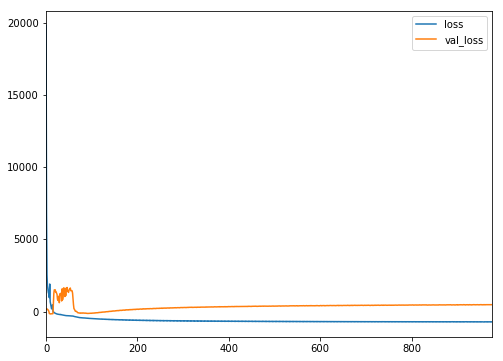

In [13]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

# Breakdown the Loss Function Components

In [14]:
vae_kl = Model(x, _output)
vae_kl.compile(optimizer='rmsprop', loss=kl_loss)
kl = vae_kl.evaluate(X_test_pca, X_test_pca, batch_size=batch_size)

vae_logx = Model(x, _output)
vae_logx.compile(optimizer='rmsprop', loss=logx_loss)
logx = vae_logx.evaluate(X_test_pca, X_test_pca, batch_size=batch_size)

print()
print("KL loss: {}".format(kl))
print("xent loss: {}".format(logx))

63000/63000 [==============================] - 2s      

# Generator Network

In [15]:
decoder_input = Input(shape=(latent_dim,))

_decoder_1 = decoder_dropout_1(decoder_1(decoder_1_batch(decoder_1_dense(decoder_input))))
_decoder_2 = decoder_dropout_2(decoder_2(decoder_2_batch(decoder_2_dense(_decoder_1))))
_decoder_3 = decoder_dropout_3(decoder_3(decoder_3_batch(decoder_3_dense(_decoder_2))))
_decoder_4 = decoder_dropout_4(decoder_4(decoder_4_batch(decoder_4_dense(_decoder_3))))
_decoder_5 = decoder_dropout_5(decoder_5(decoder_5_batch(decoder_5_dense(_decoder_4))))
_decoder_output = x_decoded_mean(_decoder_5)

generator = Model(decoder_input, _decoder_output)

# Save Generator Model

In [16]:
vae_path = "saved_models/vae.hdf5"
vae.save(vae_path)

generator_path = "saved_models/generator.hdf5"
generator.save(generator_path)